# Organization Analysis: Machine Learning Approach

## Table of Contents
- [1. Getting the data](#one)
- [2. Preparing the data](#two)
- [3. PCA Analysis](#three)
- [4. t-SNE Implementation](#four)
    - [4.1. Fixed perplexity](#four-one)
    - [4.2. Effects of perplexity](#four-two)
- [5. Hierarchical Clustering](#five)

## 1. Getting the data <a class="anchor" id="one"></a>

In [1]:
import py2neo
import pandas
import numpy
import scipy.linalg
import matplotlib.pyplot
import sklearn.manifold
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy 
%matplotlib inline
numpy.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [2]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = py2neo.Graph(local_connection_url)

Getting the name of all of the terms. 

In [3]:
def get_terms(processVariableType):
    query = """  MATCH (a:Asset)-[:CONTAINS]->(pv:{})
                 RETURN pv.term, count(pv)""".format(processVariableType)
    
    names = sorted(list(set(pandas.DataFrame(connection_to_graph.data(query)).as_matrix()[:, 1])))
    
    return names

In [4]:
process_variables_names =  {
            'Feedstock':get_terms('Feedstock'),
            'ProcessingTech':get_terms('ProcessingTech'),
            'Output':get_terms('Output'),        
        }

Getting the name of the top `top` organizations

In [5]:
def get_orgs(top):
    query = """ MATCH (n:Asset)
                WITH n.owner as ORG
                RETURN ORG, count(ORG)
                ORDER BY count(ORG) DESC"""
    
    names = sorted(list(set(pandas.DataFrame(connection_to_graph.data(query)).as_matrix()[1:top, 0])))
    
    return names    

Getting the name of some of the danish organizations in the databse. 

In [6]:
dk_organizations = ["TECH UNIV DENMARK", 
                   "NOVOZYMES AS", 
                   "AALBORG UNIV", 
                   "UNIV COPENHAGEN", 
                   "AARHUS UNIV", 
                   "GRUNDFOS MICROREFINERY AS", 
                   "UNIV SO DENMARK", 
                   "RISO DTU", 
                   "DONG ENERGY"]

In [7]:
org_names = sorted(list(set(get_orgs(150) + dk_organizations)))

Getting Occurences for any country and process variable-

In [8]:
def get_pv_org(org, processVariable):
    
    """
    Receives a organizations and a processVariable and returns the occurences of the various terms in that process variable for a given country. 
    """
    
    q = """ MATCH (a:Asset)-[:CONTAINS]->(pv:{})
            WHERE a.owner CONTAINS "{}"
            RETURN pv.term, count(pv)""".format(processVariable, org.encode('utf-8'))
    
     
    data = pandas.DataFrame(connection_to_graph.data(q)).as_matrix()
    
    org_occurences = [0] * len(process_variables_names[processVariable])
    
    if len(data) == 0:
        return org_occurences
    
    for index1, name in enumerate(process_variables_names[processVariable]):
        for index2, data_name in enumerate(data[:, 1]):
            if name == data_name:
                org_occurences[index1] = data[index2, 0]
    
    
    return org_occurences

Matrix of Feedstocks

In [9]:
def get_matrix(process_type):
    matrix = numpy.zeros((len(org_names), len(process_variables_names[process_type])))
    row = 0
    
    for org in org_names:
        matrix[row, :] = get_pv_org(org, process_type)
        row += 1
        
    return matrix    

In [10]:
feed_matrix = get_matrix('Feedstock')

Matrix of Processing Technologies

In [11]:
proc_matrix = get_matrix('ProcessingTech')

Matrix of Outputs

In [12]:
out_matrix = get_matrix('Output')

Robustness Check

In [13]:
organization = 'TECH UNIV DENMARK'
index = org_names.index(organization)
print get_pv_org(organization, 'Output') == out_matrix[index, :]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


## 2. Preparing the data <a class="anchor" id="two"></a>

Definning our X matrix. Here, every row will correspond to a organization, and every column to a particular term. 

In [14]:
X = numpy.hstack((feed_matrix,proc_matrix, out_matrix))
print 'Shape of X is: ', X.shape

Shape of X is:  (156, 352)


Let us clean the organizations that have absolutely no documents. 

In [15]:
print 'These have no docs:'
no_docs = [i for i in range(len(numpy.sum(X, axis=1))) if numpy.sum(X, axis=1)[i] == 0]
print [org_names[i] for i in no_docs]

These have no docs:
[]


We delete these organizations (or rows) from our matrix X and from our list of org names.  

In [16]:
X = numpy.delete(X, no_docs, 0)
org_names = list(numpy.delete(org_names, no_docs))

To normalize:

In [17]:
#X = (X - numpy.mean(X)) / numpy.std(X)
X = X/X.sum(axis=1, keepdims=True)

print 'Shape of X is: ', X.shape

Shape of X is:  (156, 352)


Let us then define the countries that we want to highlight during the analysis. To add a marker in the future. 

In [18]:
interesting_orgs = dk_organizations
idx = idxs = [org_names.index(e) for e in interesting_orgs]

## 3. PCA Analysis <a class="anchor" id="three"></a>

Variance Explained by Principal Components

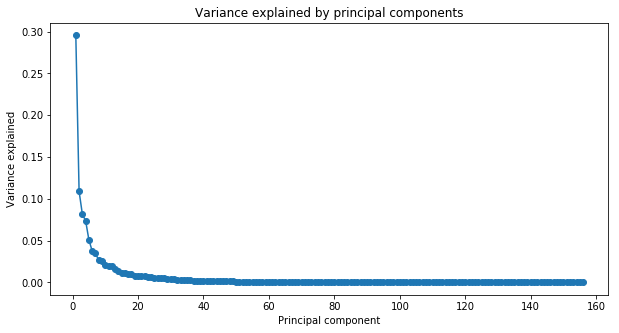

In [19]:

# PCA by computing SVD of Y
U,S,V = scipy.linalg.svd(X,full_matrices=False)

# Compute variance explained by principal components
rho = (S*S) / (S*S).sum()

# Amounts of Variation
variation = range(1,len(rho)+1)
count = 0
amount = 0

# Plot variance explained
matplotlib.pyplot.subplots(1,1,figsize=(10, 5))
matplotlib.pyplot.plot(range(1,len(rho)+1),rho,'o-')
matplotlib.pyplot.title('Variance explained by principal components')
matplotlib.pyplot.xlabel('Principal component')
matplotlib.pyplot.ylabel('Variance explained')
matplotlib.pyplot.show()

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


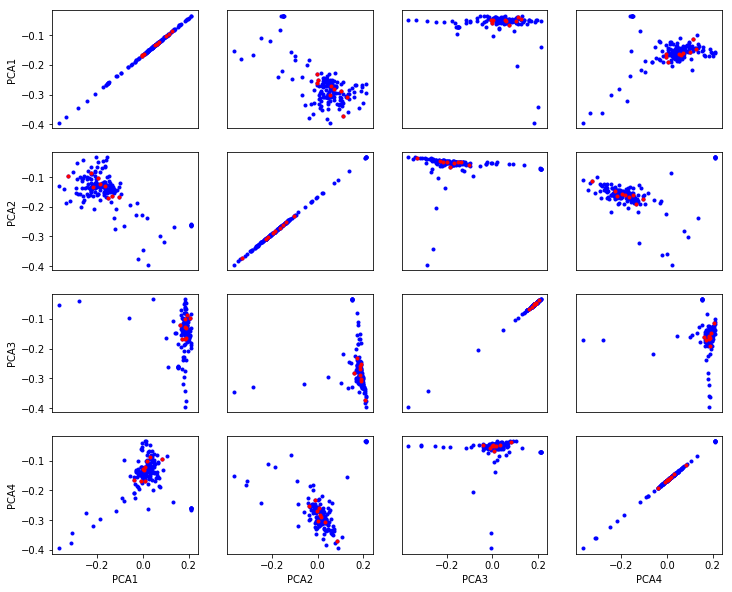

In [20]:
VT = V.T
Y = X
Z = numpy.dot(Y, VT)

# Number of PCAS to plot
k = 4

matplotlib.pyplot.figure(figsize=(12,10))
matplotlib.pyplot.hold(True)
for i in range(k):
    for j in range(k):
        matplotlib.pyplot.subplot(k, k, i*k + j + 1)
        
        matplotlib.pyplot.plot(Z[:, i], Z[:, j], '.', c='b')
        matplotlib.pyplot.plot(Z[idxs, i], Z[idxs, j], '.', c='r')
        if i==k-1:
            matplotlib.pyplot.xlabel('PCA{}'.format(j+1), fontsize=10)
        else:
            matplotlib.pyplot.xticks([])
        if j==0:
            matplotlib.pyplot.ylabel('PCA{}'.format(i+1), fontsize=10)
        else:
            matplotlib.pyplot.yticks([])


matplotlib.pyplot.show()

## 4. T-SNE Algorythm Implementation <a class="anchor" id="four"></a>

### 4.1. Fixed Perplexity <a class="anchor" id="four-one"></a>

Let us implement the T-SNE Algorithm. We will use 2 components at first for 2D visualization of the data.

In [21]:
n_components = 2
perplexity = 30
n_iter = 5000

tsne = sklearn.manifold.TSNE(n_components=n_components, init='random',random_state=0, perplexity=perplexity, n_iter=n_iter)

We fit X to the algorithm. 

In [22]:
X_embedded = tsne.fit_transform(X)

We plot the results for 2 components (2D).

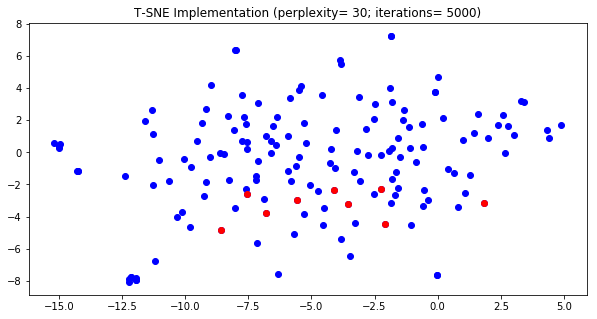

In [23]:
matplotlib.pyplot.subplots(1,1,figsize=(10, 5))
matplotlib.pyplot.scatter(X_embedded[:, 0], X_embedded[:, 1], c='b')
matplotlib.pyplot.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], c='r')
matplotlib.pyplot.title('T-SNE Implementation (perplexity= {}; iterations= {})'.format(perplexity, n_iter))
matplotlib.pyplot.show()

And for 3 components (3D).

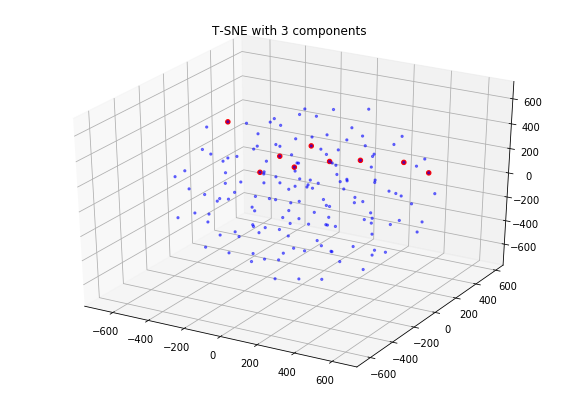

In [24]:
n_components = 3

tsne = sklearn.manifold.TSNE(n_components=n_components, init='random',random_state=0, perplexity=perplexity, n_iter=n_iter)
X_3d_embedded = tsne.fit_transform(X)


fig = matplotlib.pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = X_3d_embedded[:, 2]
ys = X_3d_embedded[:, 1]
zs = X_3d_embedded[:, 0]

xs_int = X_3d_embedded[idxs, 2]
ys_int = X_3d_embedded[idxs, 1]
zs_int = X_3d_embedded[idxs, 0]

ax.scatter(xs, ys, zs, c='b', marker='.', alpha=0.5)
ax.scatter(xs_int, ys_int, zs_int, c='r', marker='o', alpha=1.0)
ax.set_title('T-SNE with 3 components')

matplotlib.pyplot.show()

However, it is known that in the tsne algorithm, the chosing of the value of `perplexity` can have ramifications in terms of the output. Therefore, we will now try severall different values. 

### 4.2. Effects of perplexity <a class="anchor" id="four-two"></a>

As you might have noticed, we have used a single value for number of iterations (5000), and we will try different values for perplexity. This is because of the information provided in [this](https://distill.pub/2016/misread-tsne/) guide. The author states that 5000 iterations are normally enough, but that perplexity might have an impact on visualizations, hence this chapter. 

In [25]:
perplexities = [2, 5, 30, 50, 100]

Let us plot all of the possibilities. 

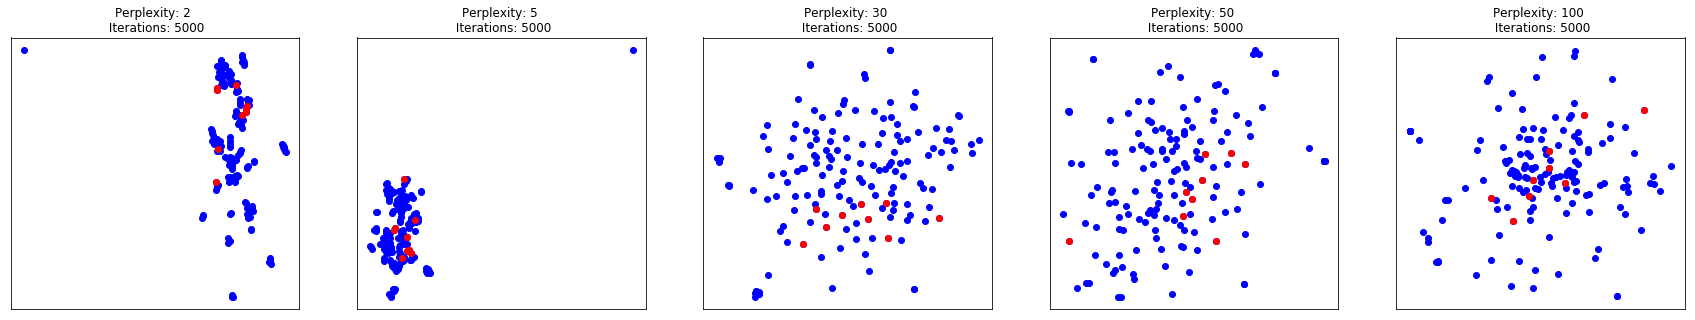

In [26]:
fig, axs = matplotlib.pyplot.subplots(1, len(perplexities), figsize=(30, 5))
for i in range(len(perplexities)):
    tsne = sklearn.manifold.TSNE(n_components=2, init='random',random_state=0, perplexity=perplexities[i], n_iter=5000)
    X_embedded = tsne.fit_transform(X)
    axs[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c='b')
    axs[i].scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], c='r')
    axs[i].set_title('Perplexity: {} \n Iterations: {}'.format(perplexities[i], n_iter))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
matplotlib.pyplot.show()

The effect here is noticeable.

## 5. Hierarchical Clustering <a class="anchor" id="five"></a>

Let us start by plotting the first two attributes of our matrix.

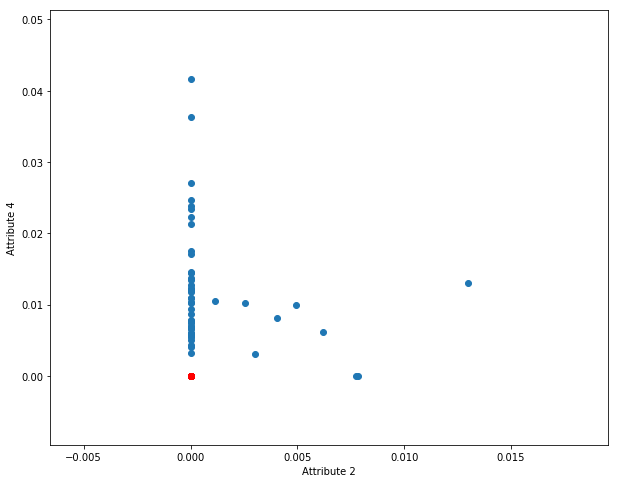

In [27]:
first_attribute = 2
second_attribute = 4

plt.figure(figsize=(10, 8))
plt.scatter(X[:,first_attribute], X[:,second_attribute])  # plot all points
plt.scatter(X[idxs,0], X[idxs,1], c='r')  # plot interesting points in red again
plt.xlabel('Attribute {}'.format(first_attribute))
plt.ylabel('Attribute {}'.format(second_attribute))
plt.show()

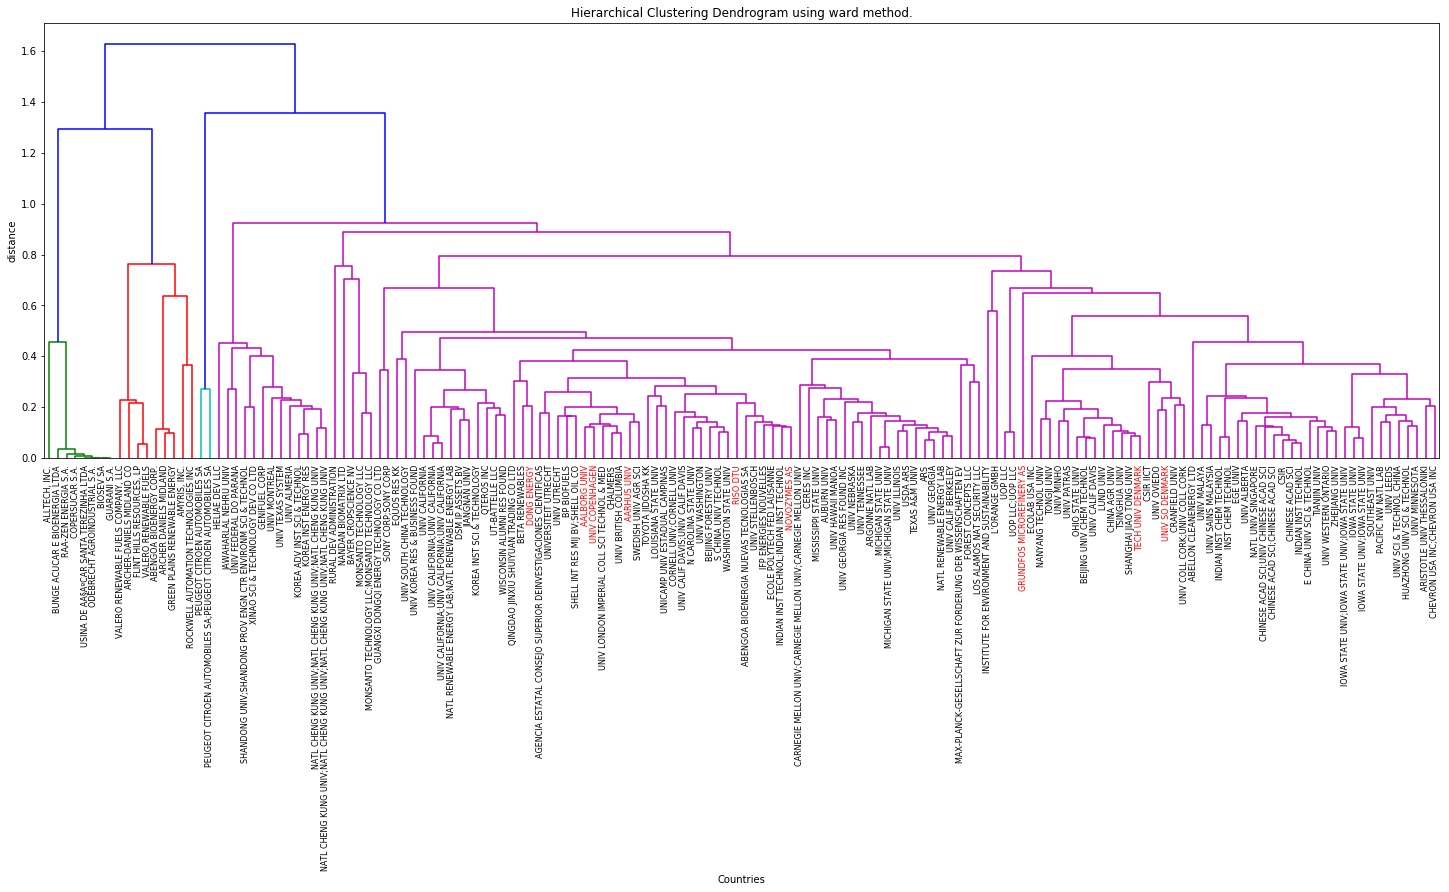

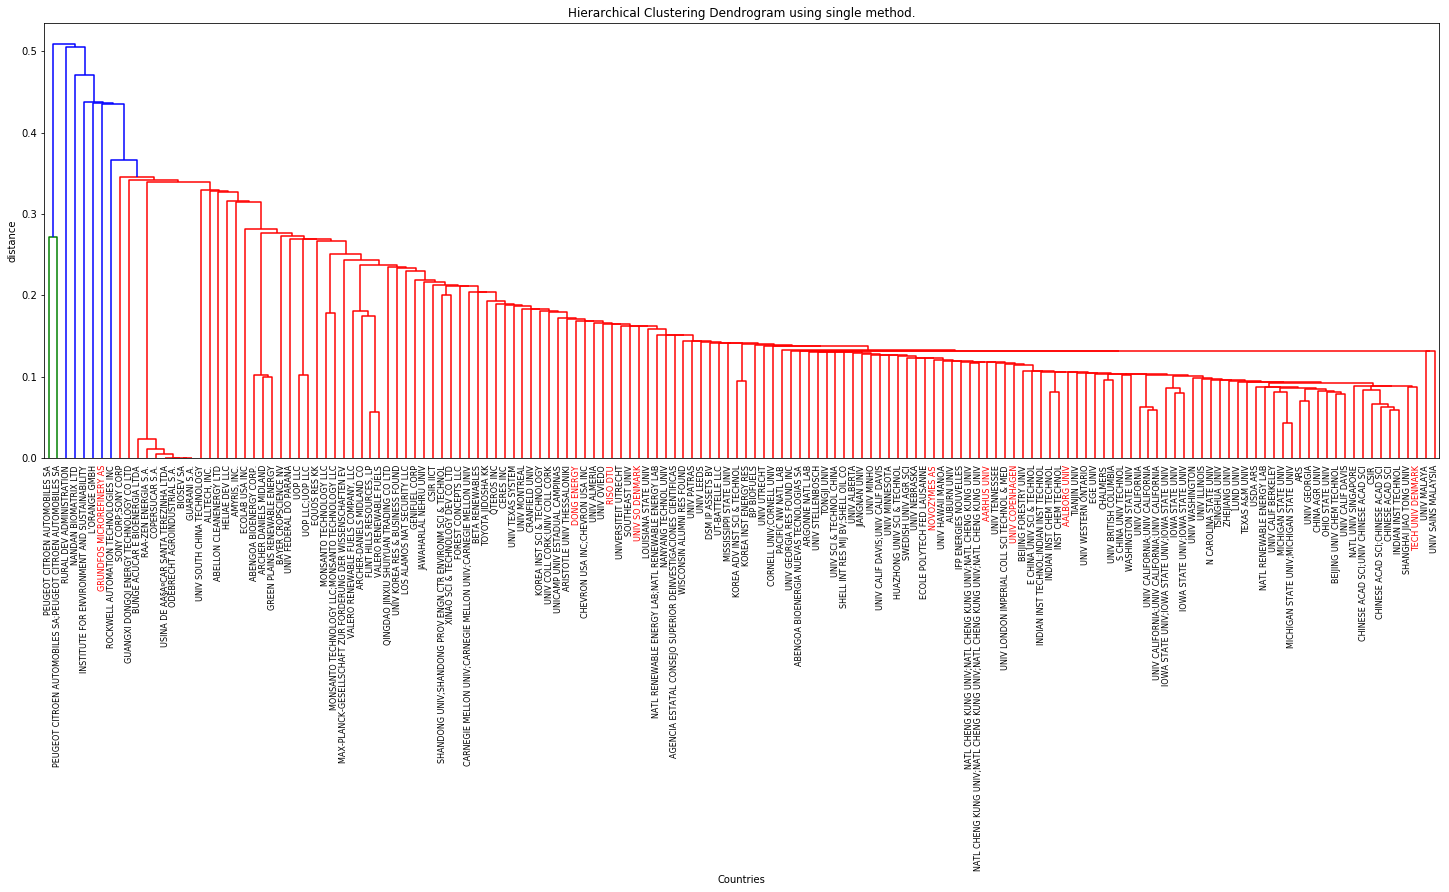

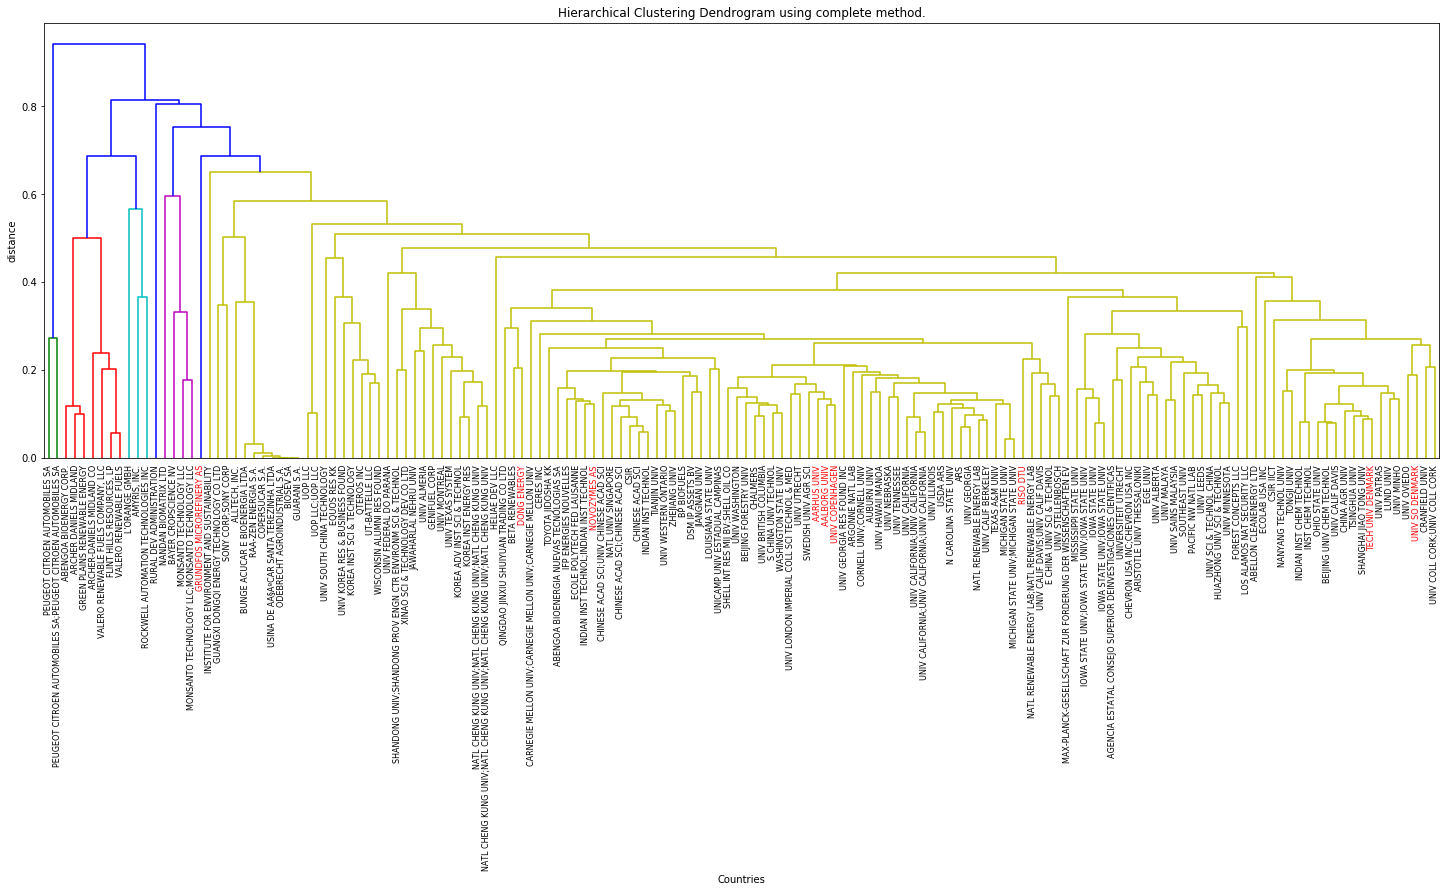

In [28]:
clustering_methods = ['ward', 'single', 'complete']

for clustering_method in clustering_methods:
    
    Z = scipy.cluster.hierarchy.linkage(X, clustering_method)
    
    plt.figure(figsize=(25, 8))
    plt.title('Hierarchical Clustering Dendrogram using {} method.'.format(clustering_method))
    plt.xlabel('Countries')
    plt.ylabel('distance')
    scipy.cluster.hierarchy.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels = org_names
    )
    
    # Assignment of colors to labels: 'a' is red, 'b' is green, etc.
    my_label_colors = {}

    for name in org_names:
        if name in dk_organizations:
            my_label_colors[name] = 'r'
        else:
            my_label_colors[name] = 'black'


    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(my_label_colors[lbl.get_text()])
    plt.show()
    